# Expanding the measurement of culture with a sample of two billion humans

## Replication Data and Code

This notebook provides all the steps to replicate the results of our paper [Expanding the measurement of culture with a sample of two billion humans](https://doi.org/10.1098/rsif.2022.0085) published in the *Journal of the Royal Society Interface 19:20220085* (2022).

## Robustness Analysis
## Analysis by Facebook Categories

# Setup and Pre-requisites

Let's start by importing the required packages

In [1]:
#%pylab --no-import-all
%matplotlib inline

import sys, os, time
import numpy as np
import pandas as pd
pd.set_option('display.width', 160)
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, manhattan_distances, pairwise_distances
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import spatial, stats
from scipy.stats import zscore
import MantelTest.MantelTest as MantelTest
import re
import seaborn as sns

Let's setup our paths

In [2]:
pathfb = './data/'
pathfbor = './data/OriginalData/'
pathregs = pathfb + 'Regs/'
pathsamples = pathfb + '/DemographicData/'  

pathout = pathregs + 'Categories/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathshare = pathout
if os.path.exists(pathfbor) == False:
    os.mkdir(pathfbor)

## Import Data

## Merge all the category distances and compare them to original FB and other measures

In [27]:
mycats = [f[f.find('_')+1:f.find('.')] for f in os.listdir(pathout) if f.endswith('dta')]
mycats.sort()
mycats

['BusinessIndustry',
 'Education',
 'Empty',
 'FamilyRelationships',
 'FitnessWellness',
 'FoodDrink',
 'HobbiesActivities',
 'LifestyleCulture',
 'NewsEntertainment',
 'NonLocalBus',
 'People',
 'ShoppingFashion',
 'SportsOutdoors',
 'Technology',
 'TravelPlacesEvents']

In [8]:
# Type of distance measure
m = 'Cos'

# Load data other distances  
df = pd.read_stata(pathregs + 'AllDistsFull.dta')

for c in mycats:
    fbdist2 = pd.read_stata(pathout + 'FB' + m + 'Dist_' + c + '.dta')
    cols = fbdist2.columns.tolist()
    cols[0] = 'ISO_CODE_1'
    fbdist2.columns = cols
    fbdist2 = fbdist2.set_index('ISO_CODE_1').stack().copy()
    fbdist2 = fbdist2.reset_index()
    fbdist2.columns = ['ISO_CODE_1', 'ISO_CODE_2', 'FBDist_'+c]
    df = df.merge(fbdist2, on=['ISO_CODE_1', 'ISO_CODE_2'], how='left')

In [9]:
df.head()

,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,CosDist7,CosDist8,...,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,AD,AD,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,AD,AE,0.649726,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
2,AD,AF,0.027777,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
3,AD,AG,0.298230,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
4,AD,AI,0.917672,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484


In [10]:
# Import all distances
mypairs = pd.read_stata(pathregs + 'AllDists.dta')

# Merge category distances
mypairs = mypairs.merge(df[df.columns.difference(mypairs.columns).tolist() + ['ISO_CODE_1', 'ISO_CODE_2']], how='left', on=['ISO_CODE_1', 'ISO_CODE_2'])
mypairs.drop([x for x in mypairs.columns if x.endswith('uk') or x.endswith('usa')], inplace=True, axis=1)
mypairs.drop([x for x in mypairs.columns if x.find('cognate')!=-1], inplace=True, axis=1)


In [11]:
mypairs

,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,CosDist7,CosDist8,...,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,AD,AE,0.649726,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
1,AD,AF,0.027777,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
2,AD,AG,0.298230,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
3,AD,AI,0.917672,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484
4,AD,AL,0.002674,0.998614,0.998062,1.000000,0.999967,1.000000,1.000000,1.000000,...,0.158682,0.203463,0.211969,0.104971,0.221430,0.672669,0.115245,0.234657,0.088875,0.511526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27490,YT,ZM,0.078120,0.078460,0.078460,0.078427,0.078427,0.078427,0.078427,0.078427,...,0.314180,0.264914,0.104575,0.053099,0.202428,0.674473,0.142165,0.317044,0.112804,0.425856
27491,YT,ZW,0.078103,0.078497,0.078497,0.078497,0.078497,0.078497,0.078497,0.078497,...,0.342396,0.293738,0.078400,0.051409,0.185660,0.752413,0.130497,0.398470,0.089990,0.391816
27492,ZA,ZM,0.042589,0.040391,0.040391,0.021715,0.021725,0.021725,0.021725,0.021725,...,0.131968,0.114329,0.076315,0.018861,0.104667,0.293089,0.065884,0.149984,0.051544,0.296675
27493,ZA,ZW,0.042107,0.039633,0.039633,0.021641,0.021641,0.021641,0.021641,0.021641,...,0.115236,0.112350,0.056001,0.023694,0.100517,0.430028,0.076627,0.208669,0.043190,0.263977


# Correlations Between Facebook Distances and Other Distances
## Graphical Analysis

Let's plot the correlation between all measures and our FB measure

### Pairwise correlations full sample

#### Pearson Correlations

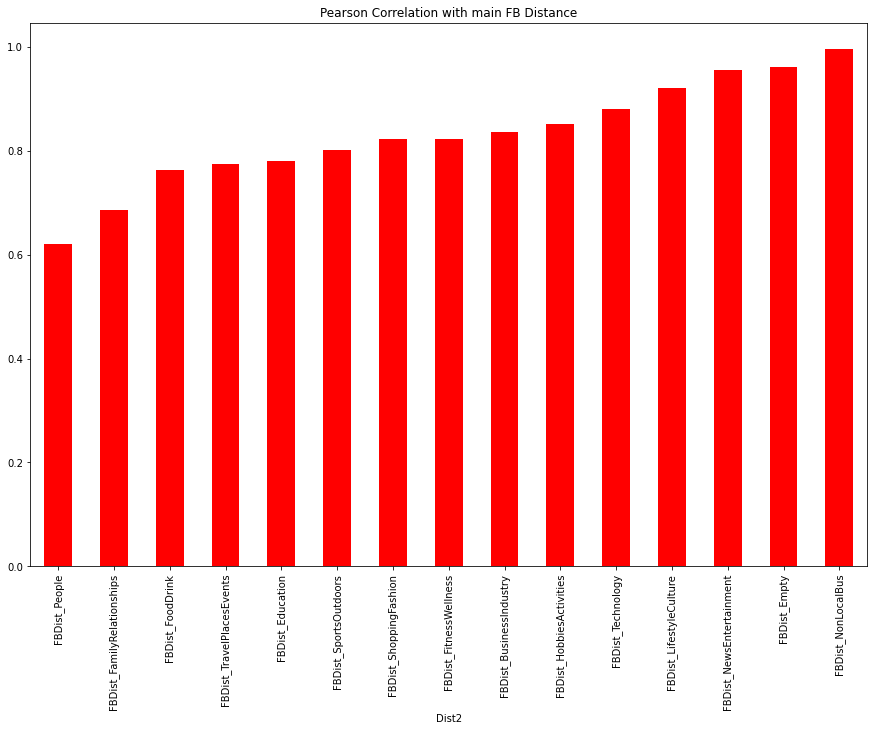

In [12]:
# All correlations
cols = ['Dist1', 'Dist2']
corrs = mypairs.corr().copy()
spear_corrs = mypairs.corr(method='spearman').copy()
corrs = corrs.stack()
spear_corrs = spear_corrs.stack()
corrs = corrs.reset_index()
spear_corrs = spear_corrs.reset_index()
corrs.columns = ['Dist1', 'Dist2', 'Corr']
spear_corrs.columns = ['Dist1', 'Dist2', 'SpCorr']
FBcorr = corrs.loc[corrs.Dist1=='FBDist'].copy()
FBspcorr = spear_corrs.loc[spear_corrs.Dist1=='FBDist'].copy()
FBcorr.reset_index(inplace=True, drop=True)
FBspcorr.reset_index(inplace=True, drop=True)
FBcorr.sort_values('Corr', inplace=True)
FBspcorr.sort_values('SpCorr', inplace=True)
FBcorr.reset_index(inplace=True, drop=True)
FBspcorr.reset_index(inplace=True, drop=True)
FBcorr = FBcorr.loc[FBcorr.Dist2!='FBDist'].copy()
FBspcorr = FBspcorr.loc[FBspcorr.Dist2!='FBDist'].copy()

fig, ax = plt.subplots(figsize=(15,10))
FBcorr.loc[FBcorr.Dist2.apply(lambda x: x.startswith('FBDist'))].plot.bar(y='Corr', x='Dist2', color='red', ax=ax)
ax.set_title('Pearson Correlation with main FB Distance')
ax.legend_.remove()
#plt.savefig(pathout+'FBcorr.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Pairwise Common Sample

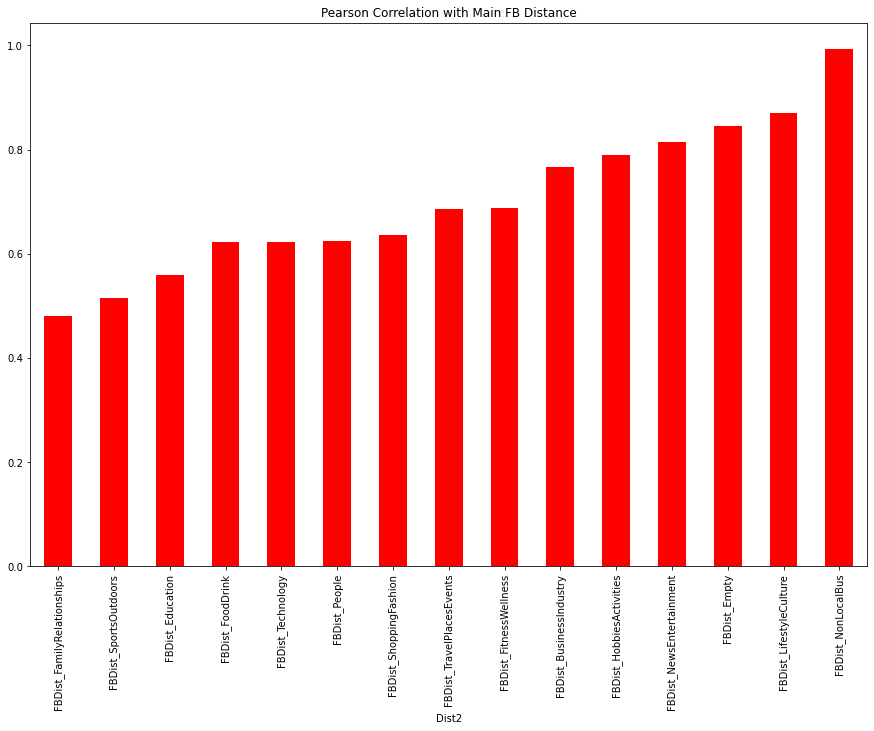

In [13]:
measures = ['FBDist', 'distcap', 'CosDist15', 'reldist_weighted_WCD_form', 'new_gendist_weighted', 'total']
mypairs_com = mypairs.dropna(subset=measures).copy()
mypairs_com.reset_index(inplace=True, drop=True)
corrs_com = mypairs_com.corr().copy()
spear_corrs_com = mypairs_com.corr(method='spearman').copy()
corrs_com = corrs_com.stack()
spear_corrs_com = spear_corrs_com.stack()
corrs_com = corrs_com.reset_index()
spear_corrs_com = spear_corrs_com.reset_index()
corrs_com.columns = ['Dist1', 'Dist2', 'Corr']
spear_corrs_com.columns = ['Dist1', 'Dist2', 'SpCorr']
FBcorr_com = corrs_com.loc[corrs_com.Dist1=='FBDist'].copy()
FBspcorr_com = spear_corrs_com.loc[spear_corrs_com.Dist1=='FBDist'].copy()
FBcorr_com.reset_index(inplace=True, drop=True)
FBspcorr_com.reset_index(inplace=True, drop=True)
FBcorr_com.sort_values('Corr', inplace=True)
FBspcorr_com.sort_values('SpCorr', inplace=True)
FBcorr_com.reset_index(inplace=True, drop=True)
FBspcorr_com.reset_index(inplace=True, drop=True)
FBcorr_com = FBcorr_com.loc[FBcorr_com.Dist2!='FBDist'].copy()
FBspcorr_com = FBspcorr_com.loc[FBspcorr_com.Dist2!='FBDist'].copy()
fig, ax = plt.subplots(figsize=(15,10))
FBcorr_com.loc[FBcorr_com.Dist2.apply(lambda x: x.startswith('FBDist'))].plot.bar(y='Corr', x='Dist2', color='red', ax=ax)
ax.set_title('Pearson Correlation with Main FB Distance')
ax.legend_.remove()
#plt.savefig(pathout+'FBcorr_com.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Prepare data for plotting

In [14]:
# Remove if Dist1==Dist2
corrs2 = corrs.loc[corrs.Dist1!=corrs.Dist2].copy()
spear_corrs2 = spear_corrs.loc[spear_corrs.Dist1!=spear_corrs.Dist2].copy()

mean_corrs = corrs2.groupby('Dist1').mean()
mean_spcorrs = spear_corrs2.groupby('Dist1').mean()
mean_corrs = mean_corrs.reset_index()
mean_spcorrs = mean_spcorrs.reset_index()
mean_corrs['Dist2'] = 'Average'
mean_spcorrs['Dist2'] = 'Average'
mean_corrs.columns = ['Dist2', 'Corr', 'Average']
mean_spcorrs.columns = ['Dist2', 'SpCorr', 'Average']

corrs_com2 = corrs_com.loc[corrs_com.Dist1!=corrs_com.Dist2].copy()
spear_corrs_com2 = spear_corrs_com.loc[spear_corrs_com.Dist1!=spear_corrs_com.Dist2].copy()

mean_corrs_com = corrs_com2.groupby('Dist1').mean()
mean_spcorrs_com = spear_corrs_com2.groupby('Dist1').mean()
mean_corrs_com = mean_corrs_com.reset_index()
mean_spcorrs_com = mean_spcorrs_com.reset_index()
mean_corrs_com['Dist2'] = 'Average'
mean_spcorrs_com['Dist2'] = 'Average'
mean_corrs_com.columns = ['Dist2', 'Corr', 'Average']
mean_spcorrs_com.columns = ['Dist2', 'SpCorr', 'Average']

# Remove FB from average
NoFBcorrs2 = corrs2.loc[np.logical_and(corrs2.Dist1!='FBDist', corrs2.Dist2!='FBDist')].copy()
NoFBspear_corrs2 = spear_corrs2.loc[np.logical_and(spear_corrs2.Dist1!='FBDist', spear_corrs2.Dist2!='FBDist')].copy()

NoFBmean_corrs = NoFBcorrs2.groupby('Dist1').mean()
NoFBmean_spcorrs = NoFBspear_corrs2.groupby('Dist1').mean()
NoFBmean_corrs = NoFBmean_corrs.reset_index()
NoFBmean_spcorrs = NoFBmean_spcorrs.reset_index()
NoFBmean_corrs['Dist2'] = 'Average (NoFB)'
NoFBmean_spcorrs['Dist2'] = 'Average (NoFB)'
NoFBmean_corrs.columns = ['Dist2', 'Corr', 'AverageNoFB']
NoFBmean_spcorrs.columns = ['Dist2', 'SpCorr', 'AverageNoFB']

NoFBcorrs_com2 = corrs_com2.loc[np.logical_and(corrs_com2.Dist1!='FBDist', corrs_com2.Dist2!='FBDist')].copy()
NoFBspear_corrs_com2 = spear_corrs_com2.loc[np.logical_and(spear_corrs_com2.Dist1!='FBDist', spear_corrs_com2.Dist2!='FBDist')].copy()

NoFBmean_corrs_com = NoFBcorrs_com2.groupby('Dist1').mean()
NoFBmean_spcorrs_com = NoFBspear_corrs_com2.groupby('Dist1').mean()
NoFBmean_corrs_com = NoFBmean_corrs_com.reset_index()
NoFBmean_spcorrs_com = NoFBmean_spcorrs_com.reset_index()
NoFBmean_corrs_com['Dist2'] = 'Average (NoFB)'
NoFBmean_spcorrs_com['Dist2'] = 'Average (NoFB)'
NoFBmean_corrs_com.columns = ['Dist2', 'Corr', 'AverageNoFB']
NoFBmean_spcorrs_com.columns = ['Dist2', 'SpCorr', 'AverageNoFB']

langcols = [i for i in mypairs.columns if re.findall(r"^\w+[Cosdist]+[0-9]{1,2}", i)!=[]]
geocols = [i for i in mypairs.columns if i.startswith('dist')]
def assign_type(x):
    '''Assign to each measure a type: Genetic, WVS, Religios, Linguistic
    '''
    if x in langcols or x.find('ling')!=-1 or x.find('cognate')!=-1 :
        y = 'Linguistic'
    elif x.find('total')!=-1 or x=='CosDistScale' or x=='CosDistBin' or x=='CosDistAll' or x=='CosDistOptions':
        y = 'Cultural'
    elif x.find('fst')!=-1 or x.find('new_gen')!=-1:
        y = 'Genetic'
    elif x.find('reldist')!=-1:
        y = 'Religious'
    elif x in geocols:
        y = 'Geographical'
    elif x=='FBDist':
        y = 'Facebook'
    elif x=='FBDist_old':
        y = 'FB_old'
    elif x.startswith('FBDist_'):
        y = 'FB Category'
    return y

NoFBcorrs3 = NoFBcorrs2.copy()
NoFBspear_corrs3 = NoFBspear_corrs2.copy()
NoFBcorrs3['DistType'] = NoFBcorrs3.Dist2.apply(assign_type)
NoFBspear_corrs3['DistType'] = NoFBspear_corrs3.Dist2.apply(assign_type)
NoFBmean_corrs3 = NoFBcorrs3.groupby(['Dist1', 'DistType']).mean()
NoFBmean_spcorrs3 = NoFBspear_corrs3.groupby(['Dist1', 'DistType']).mean()

FBcorr3 = FBcorr.copy()
FBspcorr3 = FBspcorr.copy()
FBcorr3['DistType'] = FBcorr3.Dist2.apply(assign_type)
FBspcorr3['DistType'] = FBspcorr3.Dist2.apply(assign_type)
FBmean_corrs3 = FBcorr3.groupby(['Dist1', 'DistType']).mean()
FBmean_spcorrs3 = FBspcorr3.groupby(['Dist1', 'DistType']).mean()

corrs3 = FBcorr3.append(NoFBcorrs3).copy()
spear_corrs3 = FBspcorr3.append(NoFBspear_corrs3).copy()
corrs3['DistType_1'] = corrs3.Dist1.apply(assign_type)
spear_corrs3['DistType_1'] = spear_corrs3.Dist1.apply(assign_type)
corrs3 = corrs3.loc[corrs3['DistType_1']=='Facebook'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(corrs3.loc[corrs3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)
spear_corrs3 = spear_corrs3.loc[spear_corrs3['DistType_1']=='Facebook'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(spear_corrs3.loc[spear_corrs3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)

meancorrs_types = FBmean_corrs3.append(NoFBmean_corrs3)
meanspcorrs_types = FBmean_spcorrs3.append(NoFBmean_spcorrs3)
meancorrs_types.reset_index(inplace=True)
meanspcorrs_types.reset_index(inplace=True)
meancorrs_types['DistType_1'] = meancorrs_types.Dist1.apply(assign_type)
meanspcorrs_types['DistType_1'] = meanspcorrs_types.Dist1.apply(assign_type)
meancorrs_types = meancorrs_types.loc[meancorrs_types['DistType_1']=='Facebook'].append(meancorrs_types.loc[meancorrs_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)
meanspcorrs_types = meanspcorrs_types.loc[meanspcorrs_types['DistType_1']=='Facebook'].append(meanspcorrs_types.loc[meanspcorrs_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)

NoFBcorrs_com3 = NoFBcorrs_com2.copy()
NoFBspear_corrs_com3 = NoFBspear_corrs_com2.copy()
NoFBcorrs_com3['DistType'] = NoFBcorrs_com3.Dist2.apply(assign_type)
NoFBspear_corrs_com3['DistType'] = NoFBspear_corrs_com3.Dist2.apply(assign_type)
NoFBmean_corrs_com3 = NoFBcorrs_com3.groupby(['Dist1', 'DistType']).mean()
NoFBmean_spcorrs_com3 = NoFBspear_corrs_com3.groupby(['Dist1', 'DistType']).mean()

FBcorr_com3 = FBcorr_com.copy()
FBspcorr_com3 = FBspcorr_com.copy()
FBcorr_com3['DistType'] = FBcorr_com3.Dist2.apply(assign_type)
FBspcorr_com3['DistType'] = FBspcorr_com3.Dist2.apply(assign_type)
FBmean_corrs_com3 = FBcorr_com3.groupby(['Dist1', 'DistType']).mean()
FBmean_spcorrs_com3 = FBspcorr_com3.groupby(['Dist1', 'DistType']).mean()

corrs_com3 = FBcorr_com3.append(NoFBcorrs_com3).copy()
spear_corrs_com3 = FBspcorr_com3.append(NoFBspear_corrs_com3).copy()
corrs_com3['DistType_1'] = corrs_com3.Dist1.apply(assign_type)
spear_corrs_com3['DistType_1'] = spear_corrs_com3.Dist1.apply(assign_type)
corrs_com3 = corrs_com3.loc[corrs_com3['DistType_1']=='Facebook'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(corrs_com3.loc[corrs_com3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)
spear_corrs_com3 = spear_corrs_com3.loc[spear_corrs_com3['DistType_1']=='Facebook'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(spear_corrs_com3.loc[spear_corrs_com3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)

meancorrs_com_types = FBmean_corrs_com3.append(NoFBmean_corrs_com3)
meanspcorrs_com_types = FBmean_spcorrs_com3.append(NoFBmean_spcorrs_com3)
meancorrs_com_types.reset_index(inplace=True)
meanspcorrs_com_types.reset_index(inplace=True)
meancorrs_com_types['DistType_1'] = meancorrs_com_types.Dist1.apply(assign_type)
meanspcorrs_com_types['DistType_1'] = meanspcorrs_com_types.Dist1.apply(assign_type)
meancorrs_com_types = meancorrs_com_types.loc[meancorrs_com_types['DistType_1']=='Facebook'].append(meancorrs_com_types.loc[meancorrs_com_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)
meanspcorrs_com_types = meanspcorrs_com_types.loc[meanspcorrs_com_types['DistType_1']=='Facebook'].append(meanspcorrs_com_types.loc[meanspcorrs_com_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)

# Merge Correlations
dfcorrs = FBcorr.merge(mean_corrs, on='Dist2', suffixes=['', '_Av'])
dfcorrs = dfcorrs.merge(NoFBmean_corrs, on='Dist2', suffixes=['', '_AvNoFB'])
dfspcorrs = FBspcorr.merge(mean_spcorrs, on='Dist2', suffixes=['', '_Av'])
dfspcorrs = dfspcorrs.merge(NoFBmean_spcorrs, on='Dist2', suffixes=['', '_AvNoFB'])

dfcorrs_com = FBcorr_com.merge(mean_corrs_com, on='Dist2', suffixes=['', '_Av'])
dfcorrs_com = dfcorrs_com.merge(NoFBmean_corrs_com, on='Dist2', suffixes=['', '_AvNoFB'])
dfspcorrs_com = FBspcorr_com.merge(mean_spcorrs_com, on='Dist2', suffixes=['', '_Av'])
dfspcorrs_com = dfspcorrs_com.merge(NoFBmean_spcorrs_com, on='Dist2', suffixes=['', '_AvNoFB'])

# Set seed for replication
def mymantel(Dist1, Dist2, ci=[5, 95], method='pearson', common=False, seed=128):
    '''Compute Mantel test between Distance 1 and 2'''
    np.random.seed(seed)
    if common==False:
        mydist = df[codes + [Dist1, Dist2]].copy()
    else:
        mydist = df.dropna(subset=measures)[codes + [Dist1, Dist2]].copy()
    mydist = mydist.dropna().reset_index(drop=True)
    otherdist = pd.pivot_table(mydist[codes + [Dist2]], index=codes[0], values=Dist2, columns=codes[1])
    mydist = pd.pivot_table(mydist[codes + [Dist1]], index=codes[0], values=Dist1, columns=codes[1])
    mydist = mydist.values
    np.fill_diagonal(mydist, 0)
    mydist = (mydist + mydist.T)/2
    otherdist = otherdist.values
    np.fill_diagonal(otherdist, 0)
    otherdist = (otherdist + otherdist.T)/2
    mymantel = MantelTest(mydist, otherdist, ci=ci, method=method)
    return mymantel

# FB and FBCats
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs3.copy()
corrs3m = corrs3m.loc[corrs3m.DistType=='FB Category']
corrs3m = corrs3m.loc[corrs3m.DistType_1=='Facebook']
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']

## Correlation between Main Facebook Measure and Category-based Measures

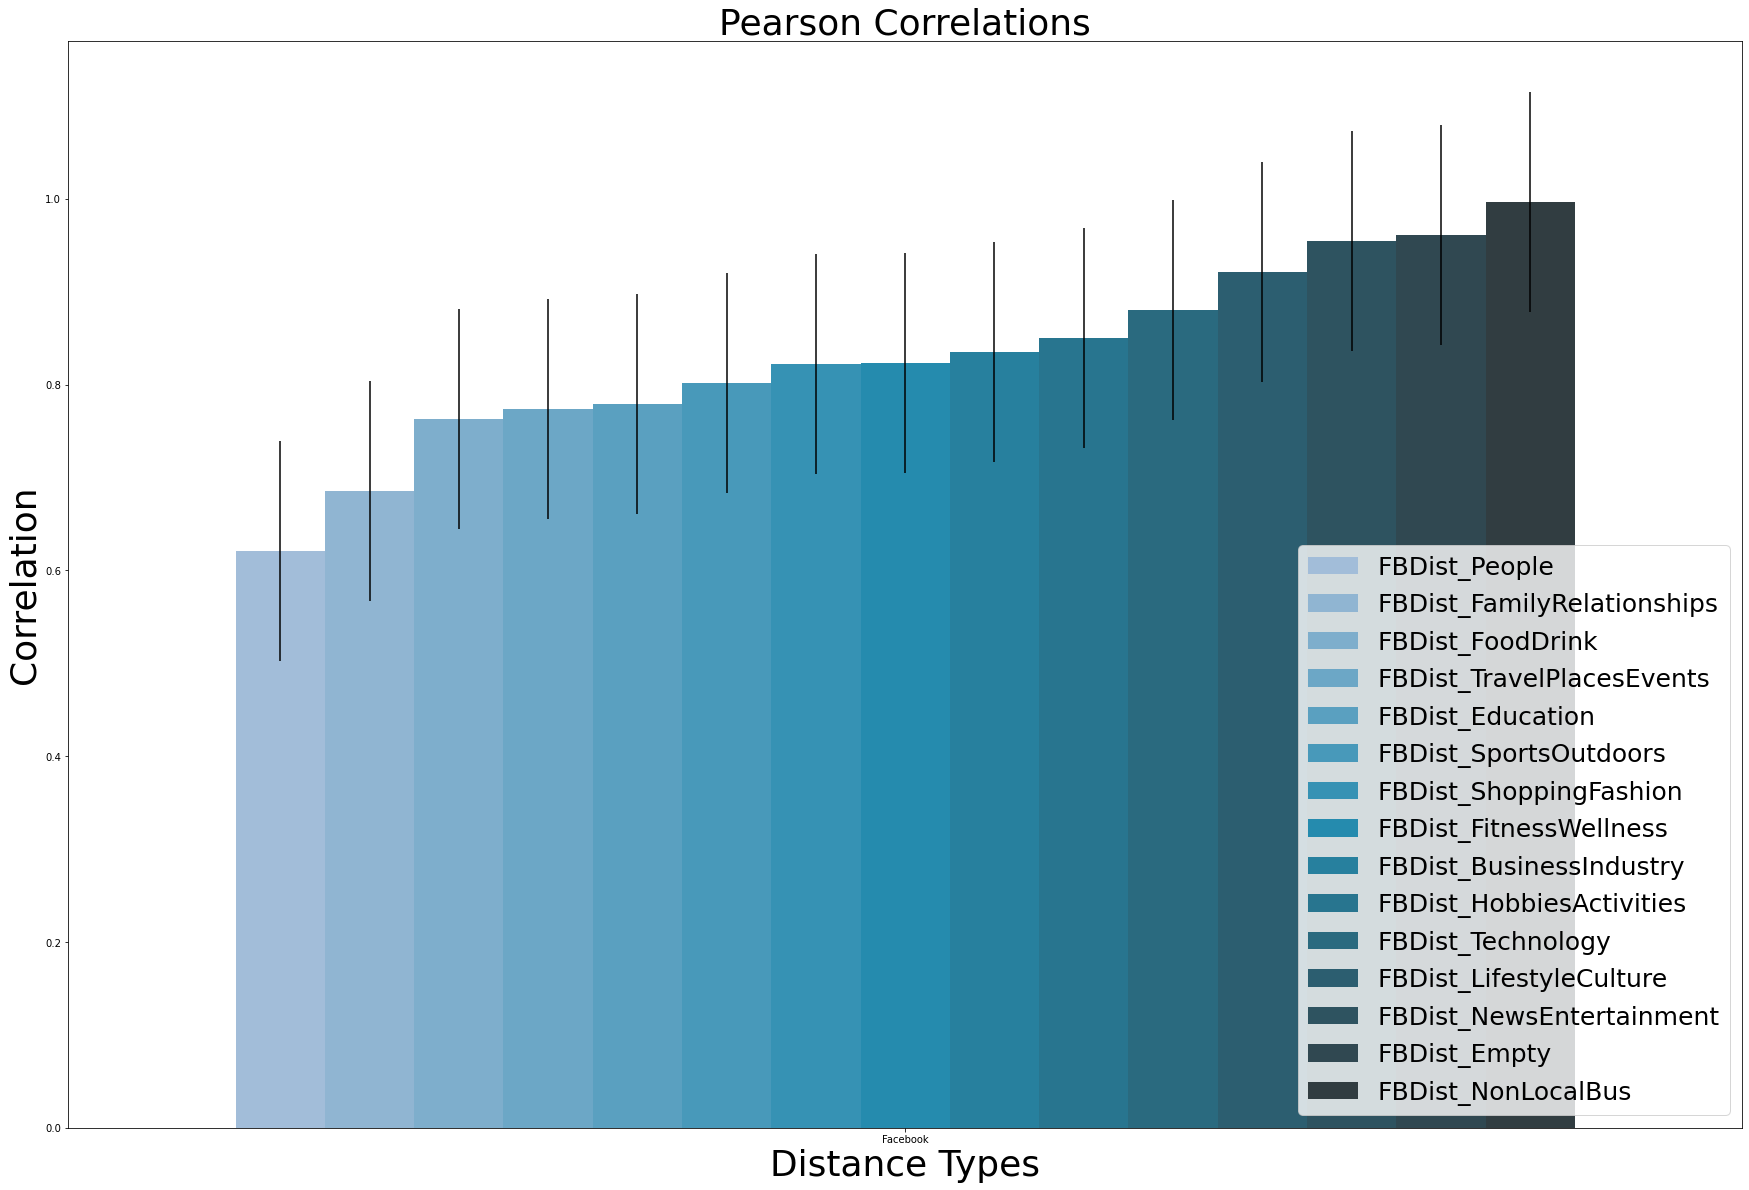

In [15]:
fig, ax = plt.subplots(figsize=(30,20))
sns.barplot(x="DistType_1", y="mycorr", hue="Dist2", data=corrs3m.loc[corrs3m.DistType_1=='Facebook'], palette='PuBuGn_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=corrs3m.loc[corrs3m.DistType_1=='Facebook', 'myerr'].max())
ax.set_title('Pearson Correlations', fontsize=36)
ax.set_ylabel('Correlation', fontsize=36)
ax.set_xlabel('Distance Types', fontsize=36)
ax.legend(loc='lower right', prop={'size': 25})
#plt.savefig(pathout+'CorrsFBCats.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Correlation between Facebook Category-based Distance and Other Distances

In [16]:
# FB Cats and WVS
# Full Sample
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs3.copy()
corrs3m = corrs3m.loc[corrs3m.DistType_1=='FB Category']
corrs3m = corrs3m.loc[corrs3m.DistType!='Facebook']
corrs3m = corrs3m.loc[corrs3m.Dist2.apply(lambda x: x in measures)]
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
corrs3m = corrs3m.sort_values(['DistType', 'mycorr', 'Dist1', ]).reset_index(drop=True)

In [24]:
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
name_dict = {'BusinessIndustry':'H',
 'Education':'K',
 'Empty':'D',
 'FamilyRelationships':'N',
 'FitnessWellness':'M',
 'FoodDrink':'I',
 'HobbiesActivities':'E',
 'LifestyleCulture':'B',
 'NewsEntertainment':'F',
 'NonLocalBus':'O',
 'People':'A',
 'ShoppingFashion':'G',
 'SportsOutdoors':'J',
 'Technology':'L',
 'TravelPlacesEvents':'C'}

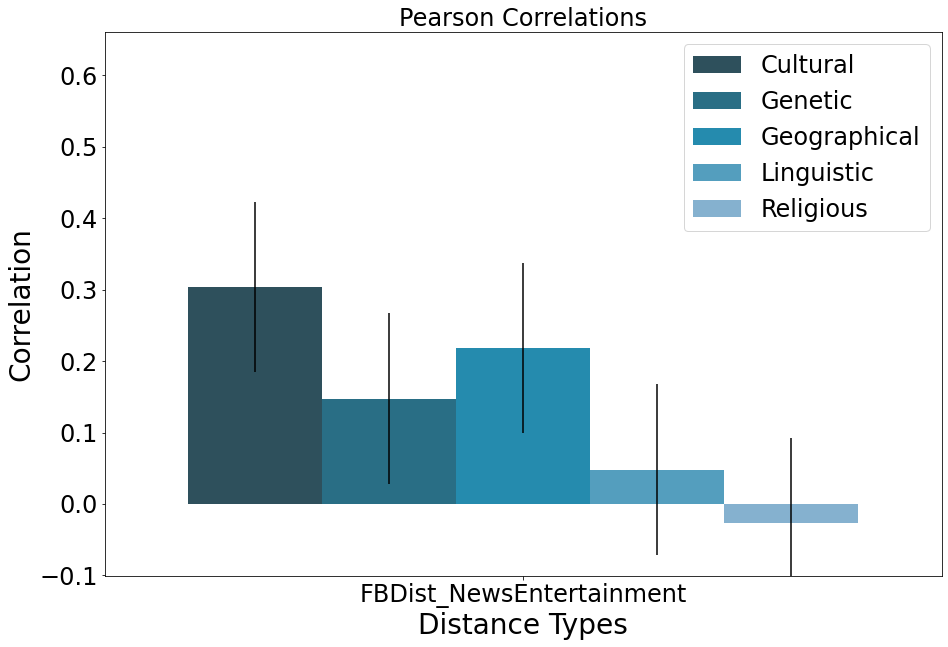

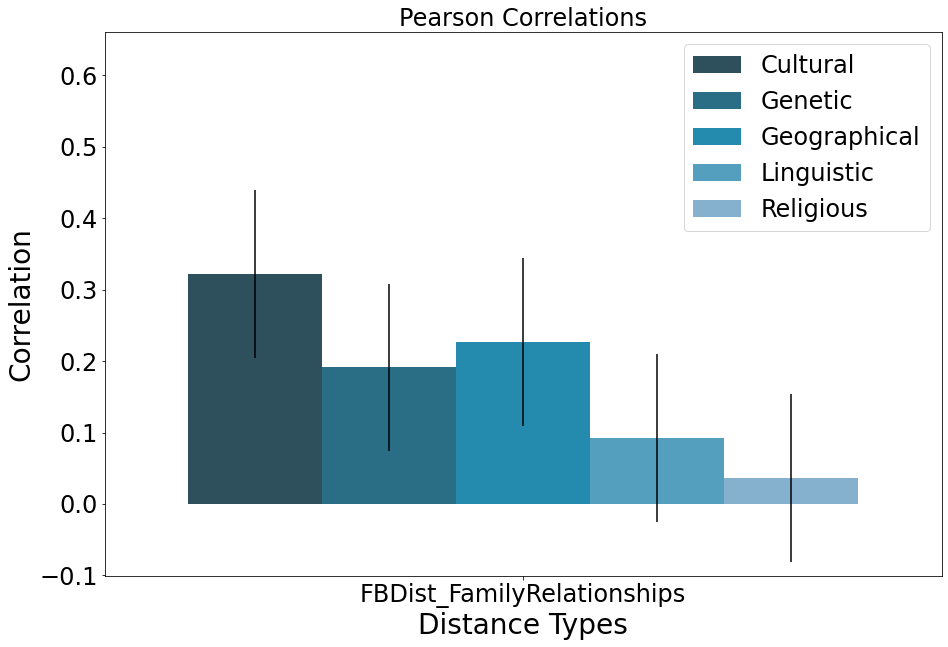

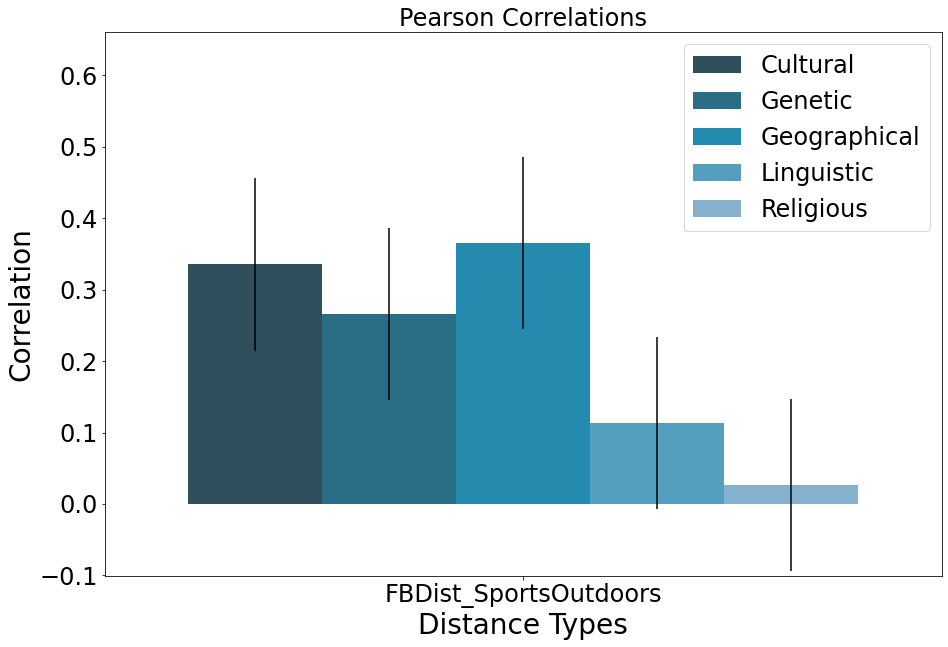

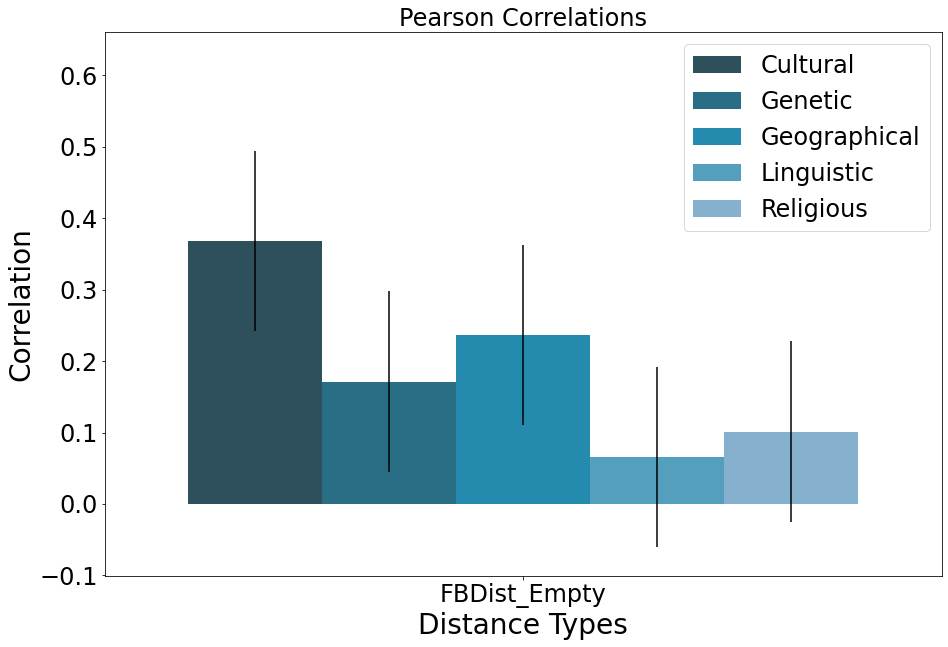

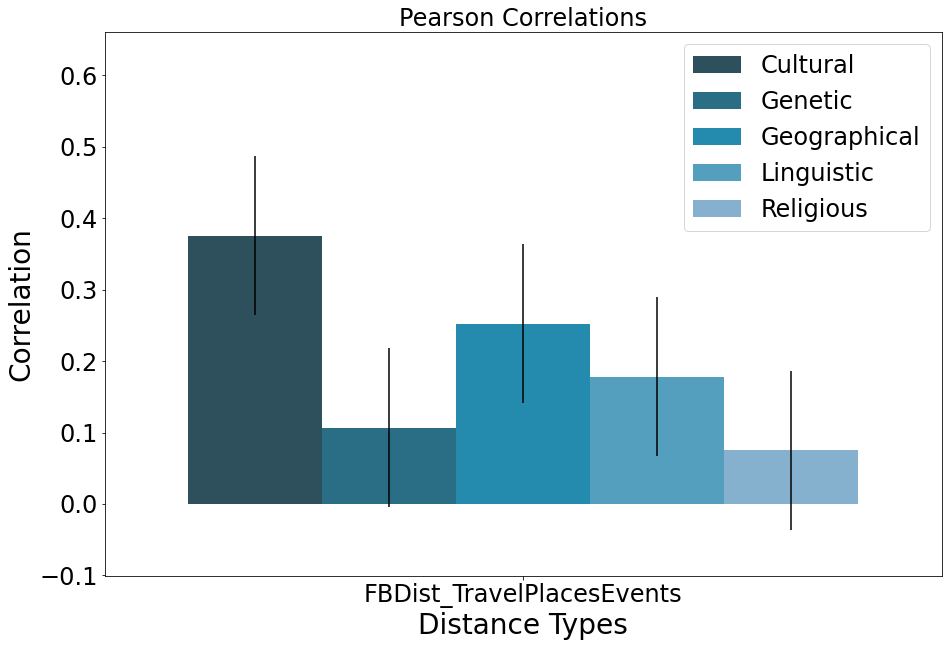

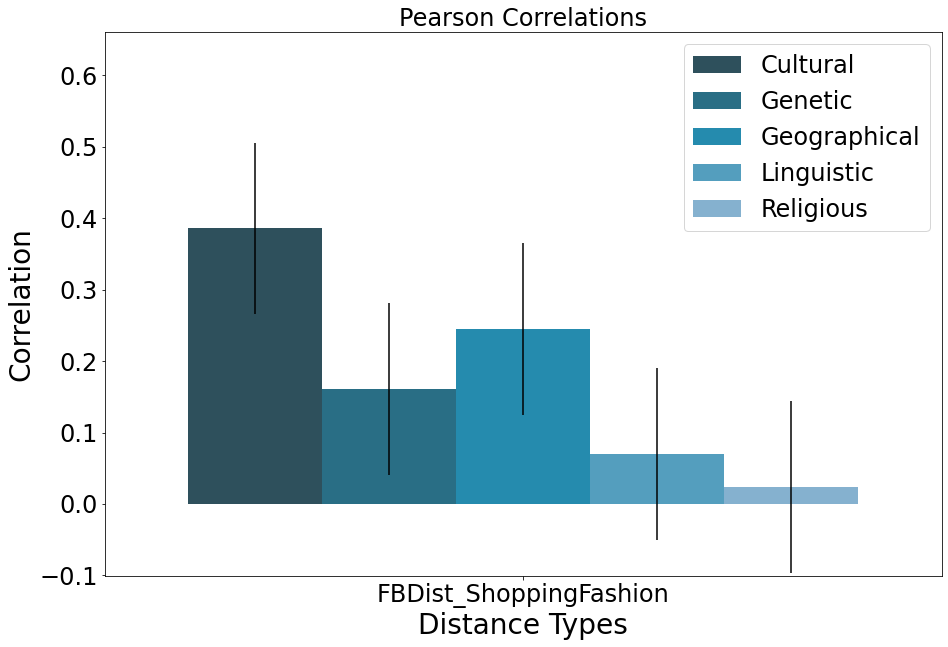

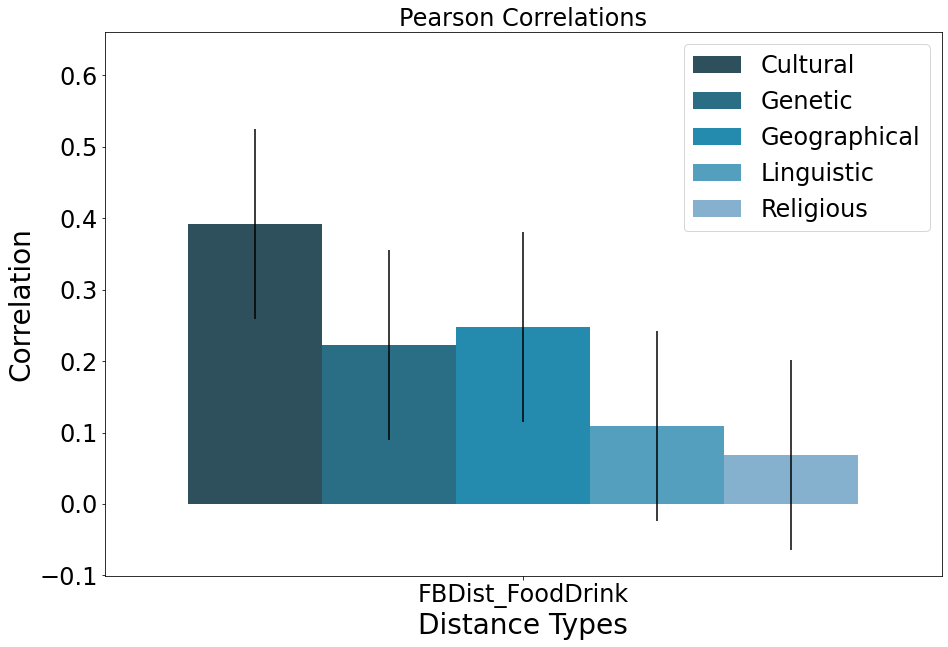

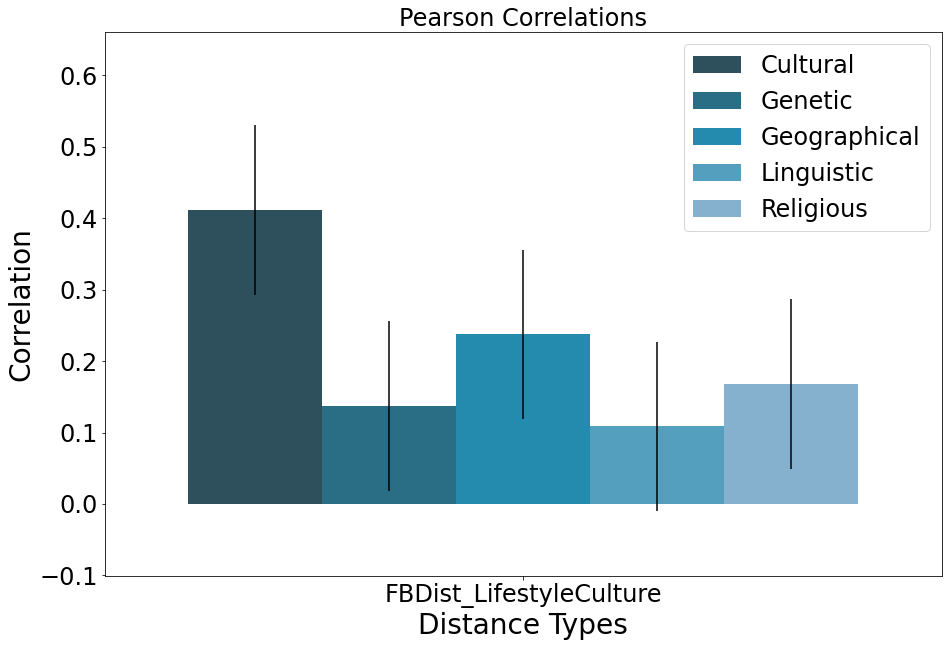

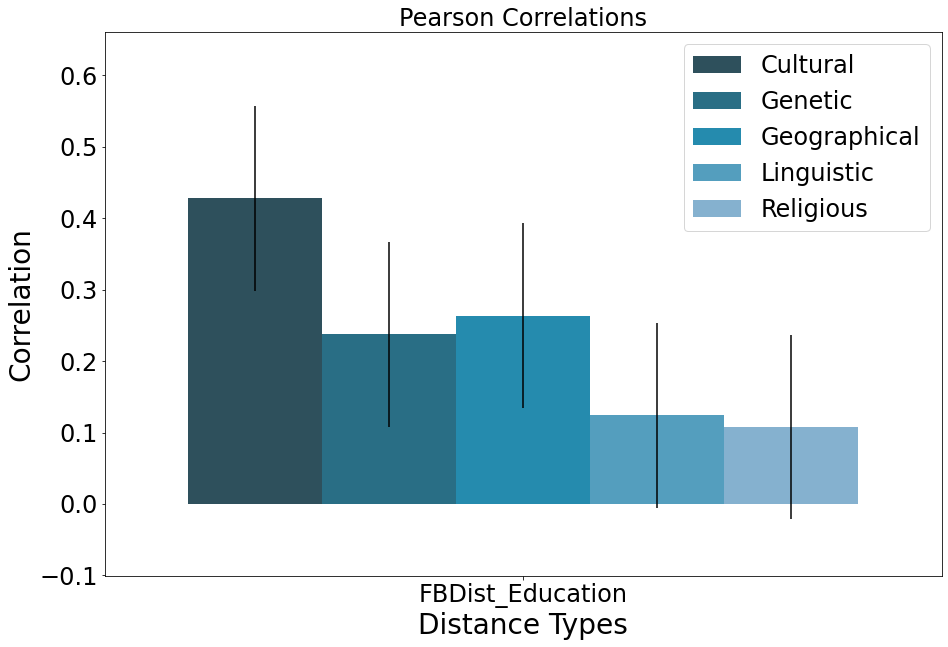

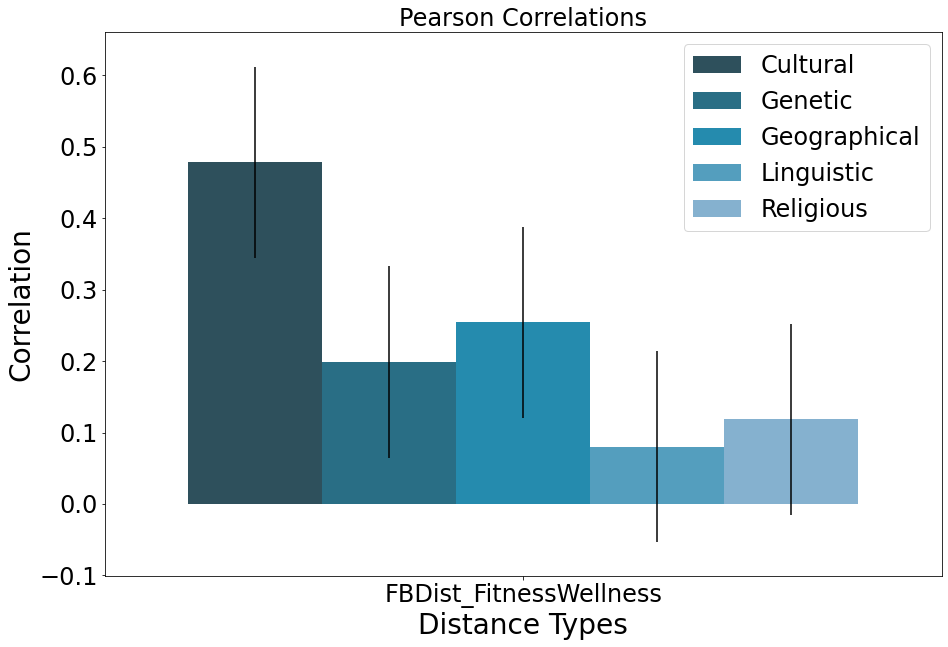

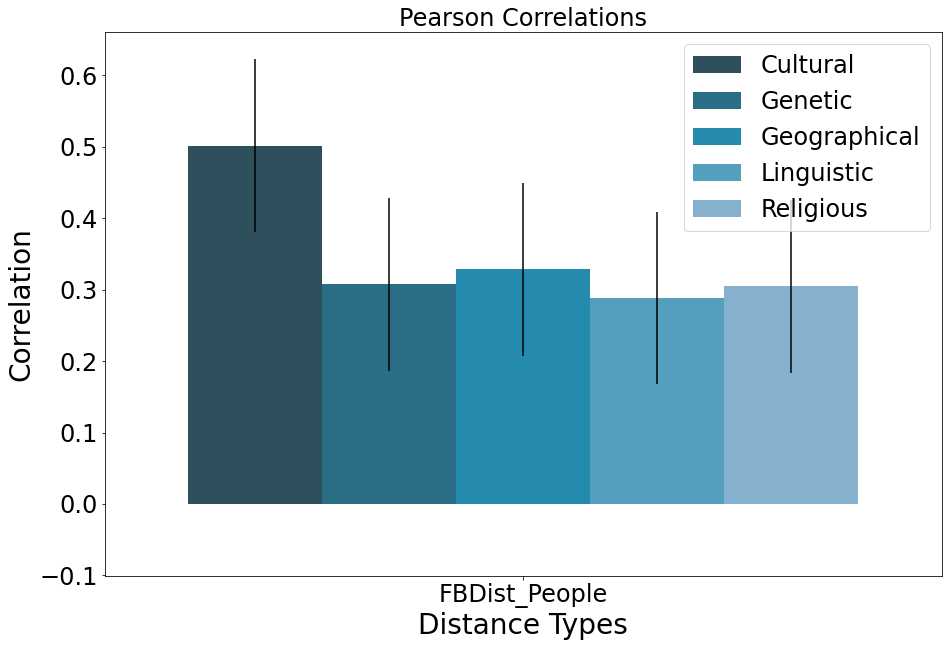

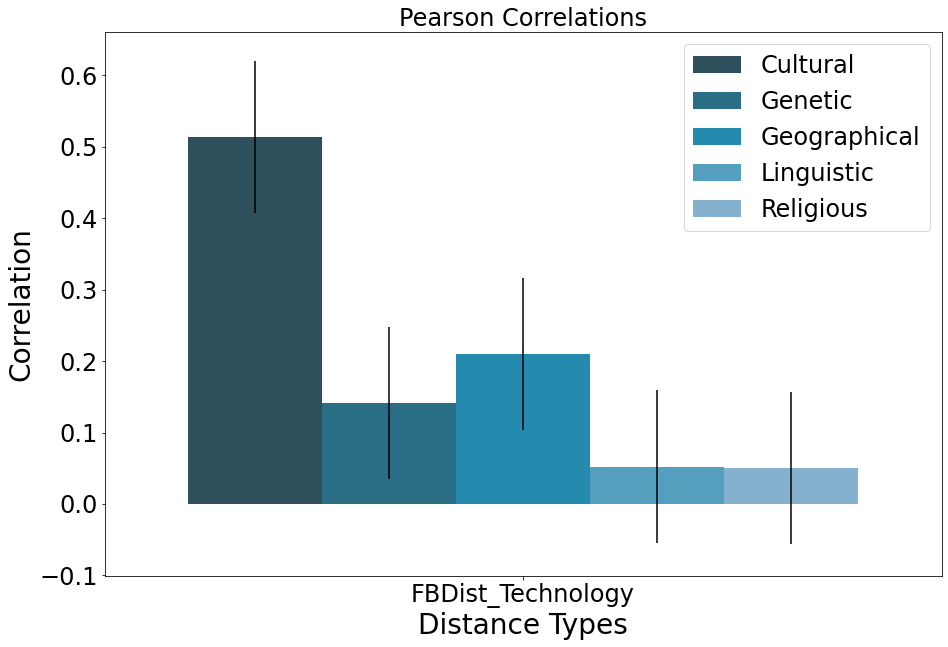

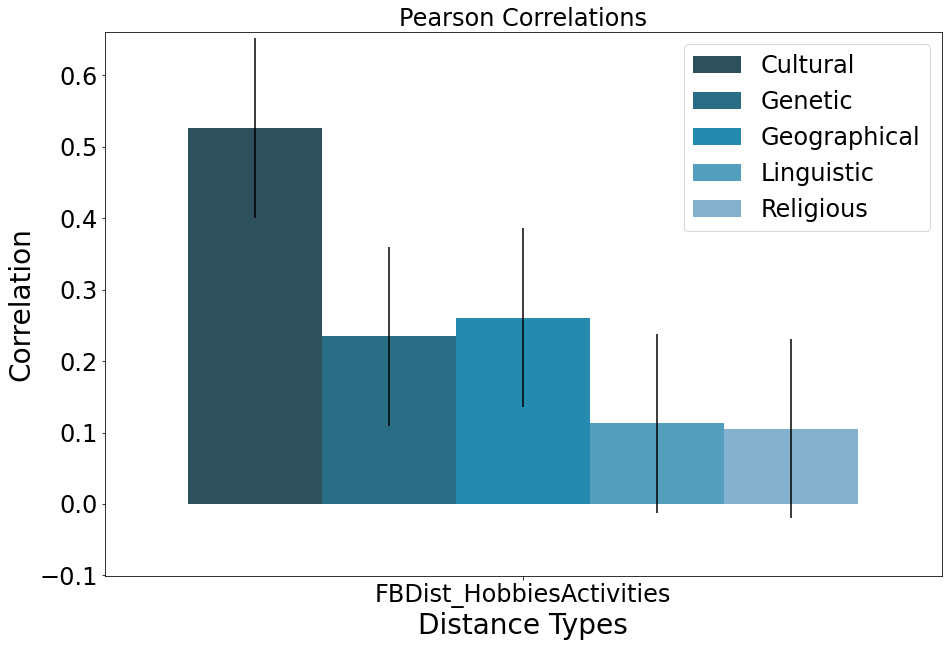

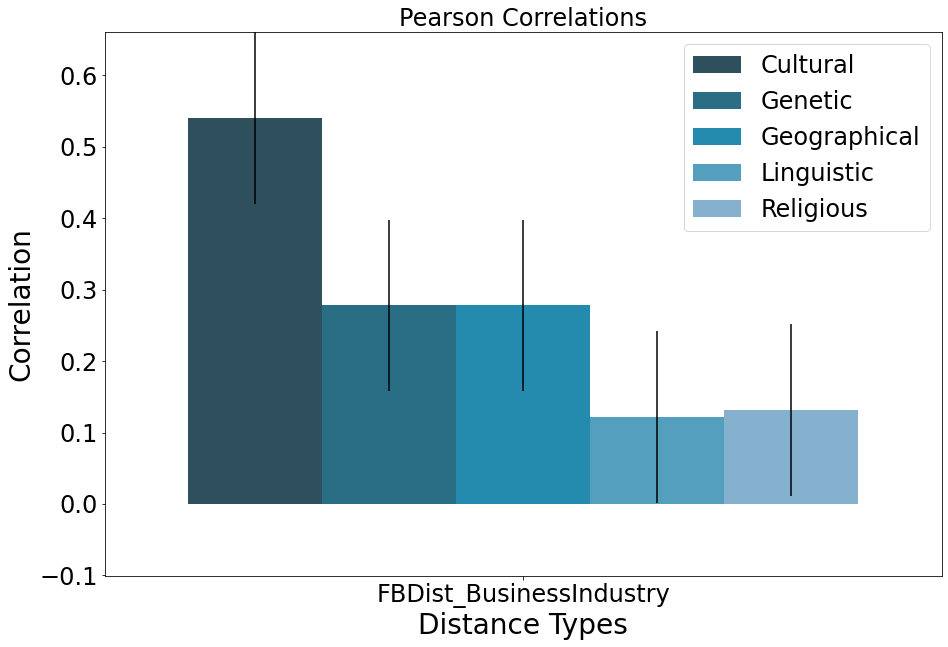

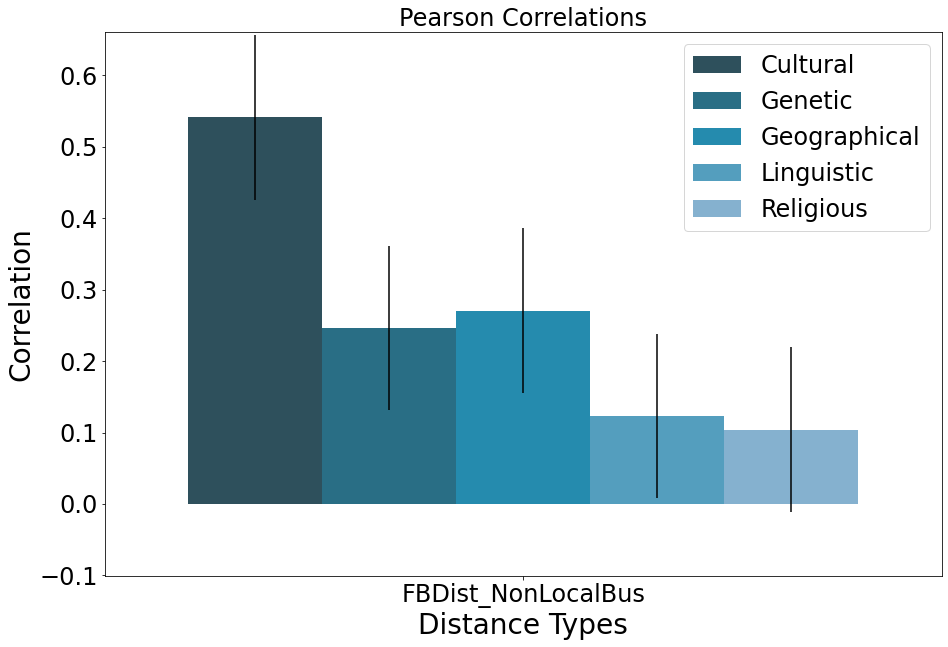

In [38]:
myfigs = []
for f in corrs3m.Dist1.unique():
    lbound = corrs3m.mylci.min()
    ubound = corrs3m.mycci.max()
    fig, ax = plt.subplots(figsize=(15,10))
    sns.barplot(x="Dist1", y="mycorr", hue="DistType", data=corrs3m.loc[corrs3m.Dist1==f], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=corrs3m.loc[corrs3m.Dist1==f, 'myerr'].max())
    ax.set_ylim(bottom=lbound, top=ubound)
    ax.set_title('Pearson Correlations')
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Distance Types')
    ax.legend(loc='upper right')
    plt.savefig(pathout+'Figure-B11-' + name_dict[f[f.find('_')+1:]] + '.pdf', dpi=300, bbox_inches='tight')
    myfigs.append(fig)
    plt.show()

### Common Sample

In [39]:
# Common Sample
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs_com3.copy()
corrs3m = corrs3m.loc[corrs3m.DistType_1=='FB Category']
corrs3m = corrs3m.loc[corrs3m.DistType!='Facebook']
corrs3m = corrs3m.loc[corrs3m.Dist2.apply(lambda x: x in measures)]
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2, common=True), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
corrs3m = corrs3m.sort_values(['DistType', 'mycorr', 'Dist1', ]).reset_index(drop=True)

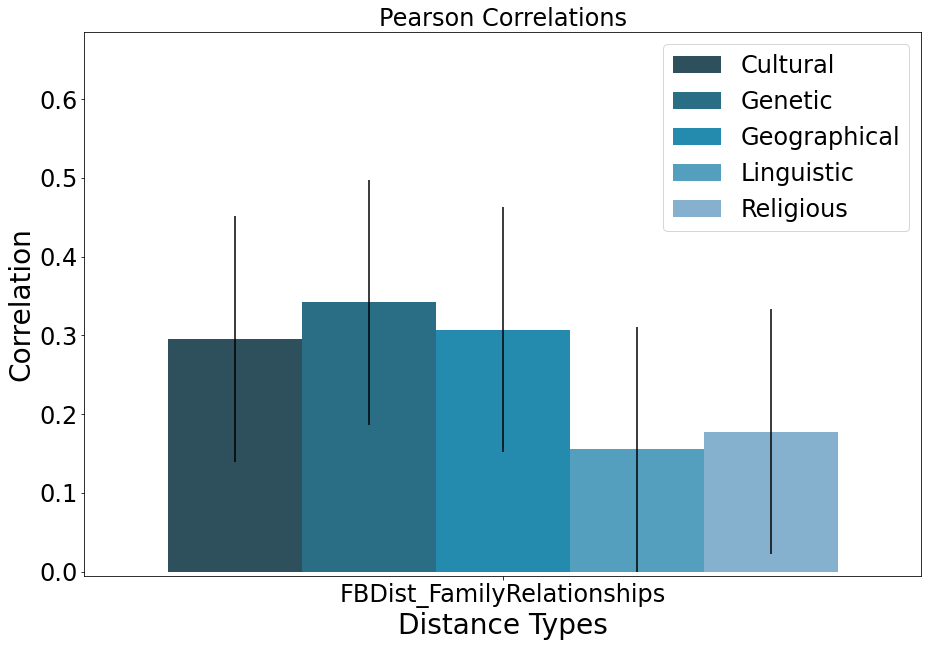

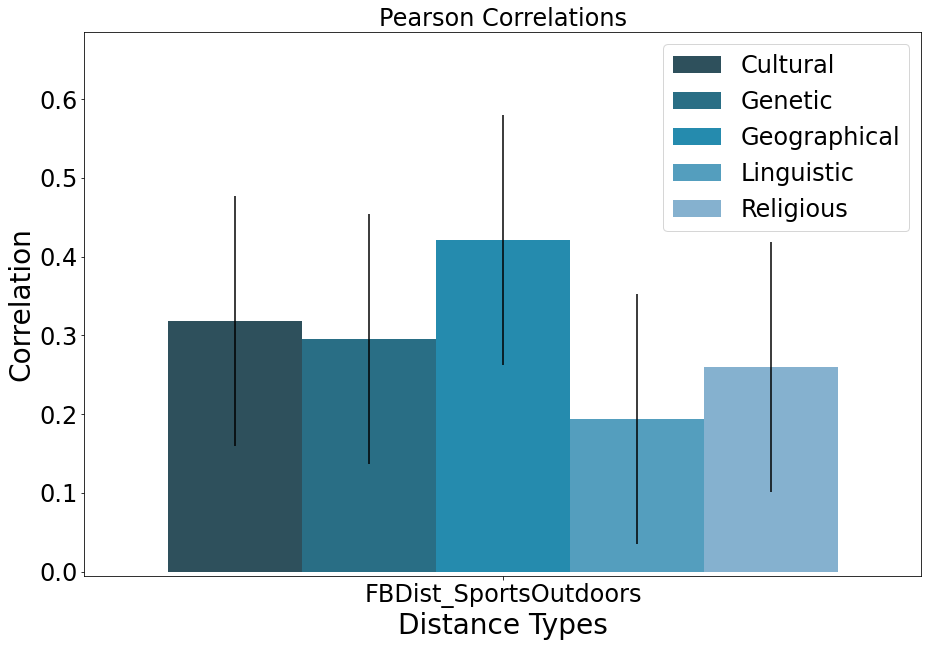

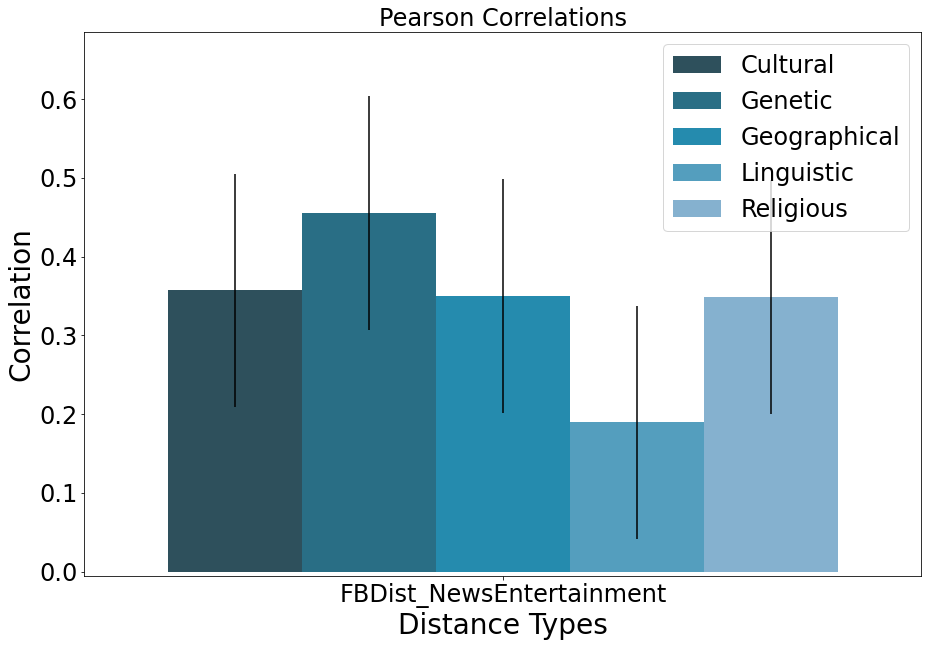

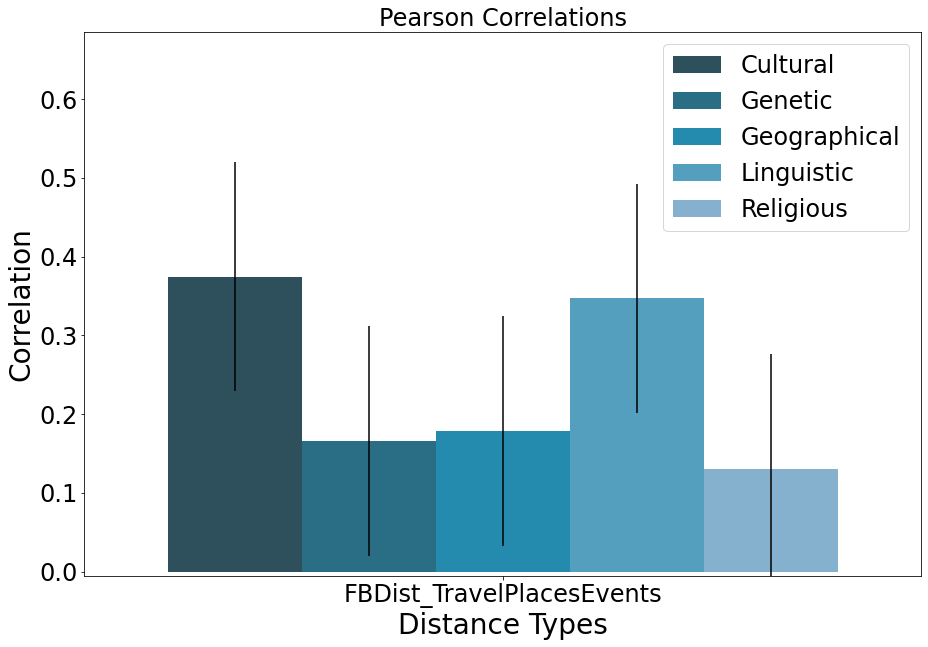

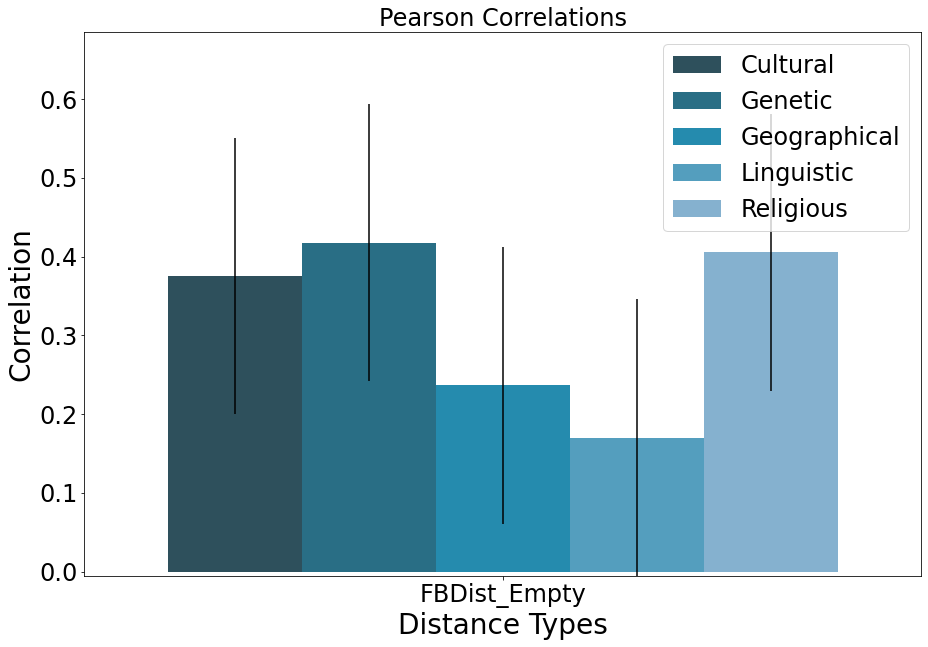

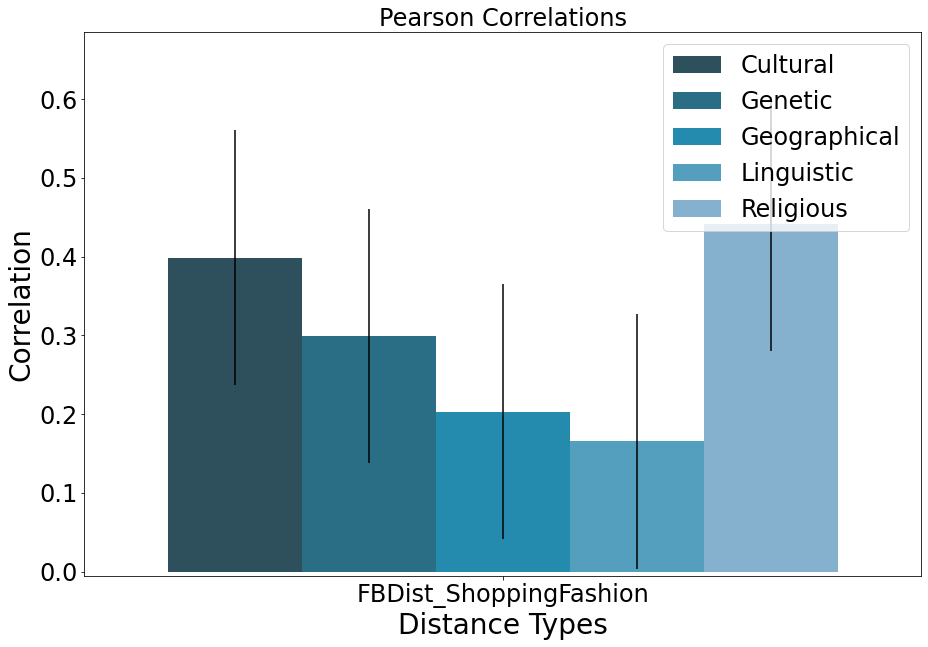

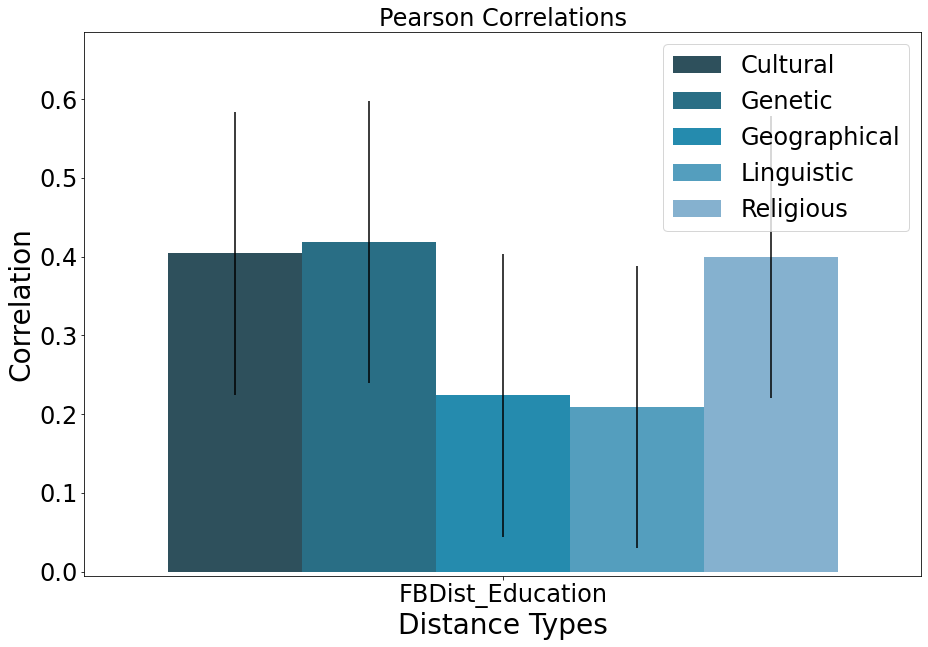

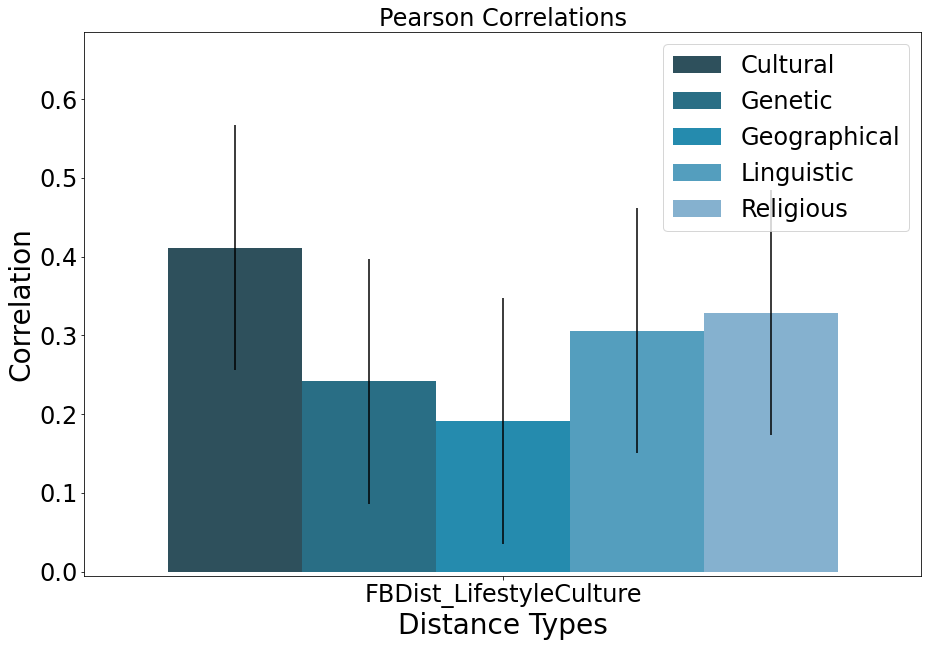

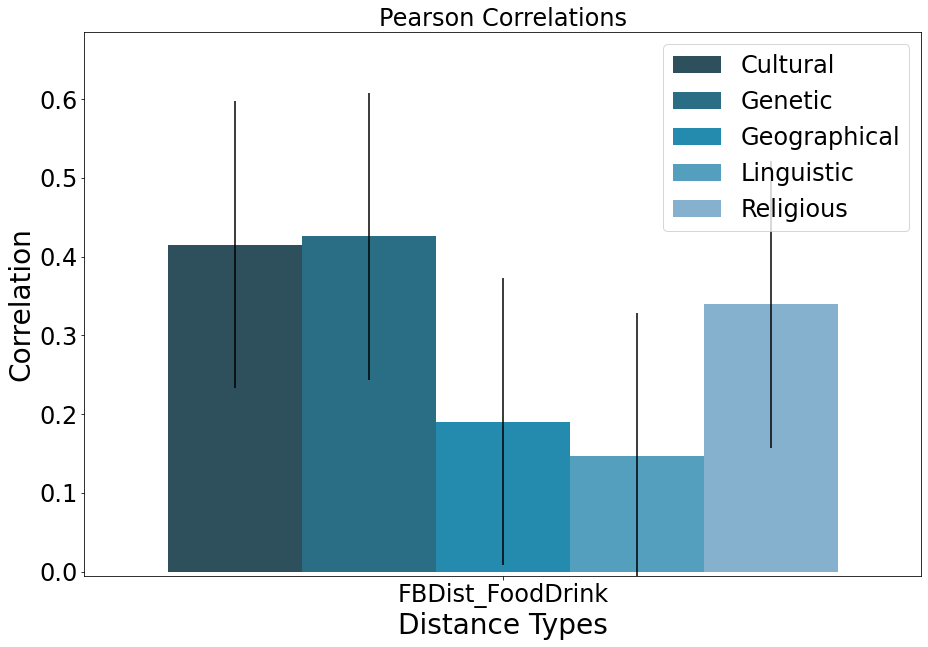

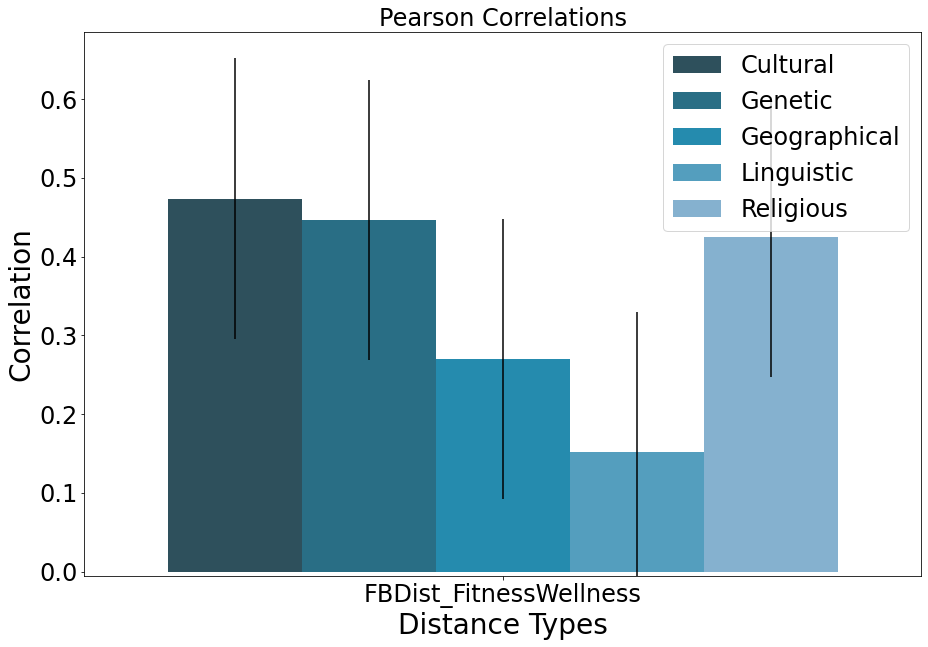

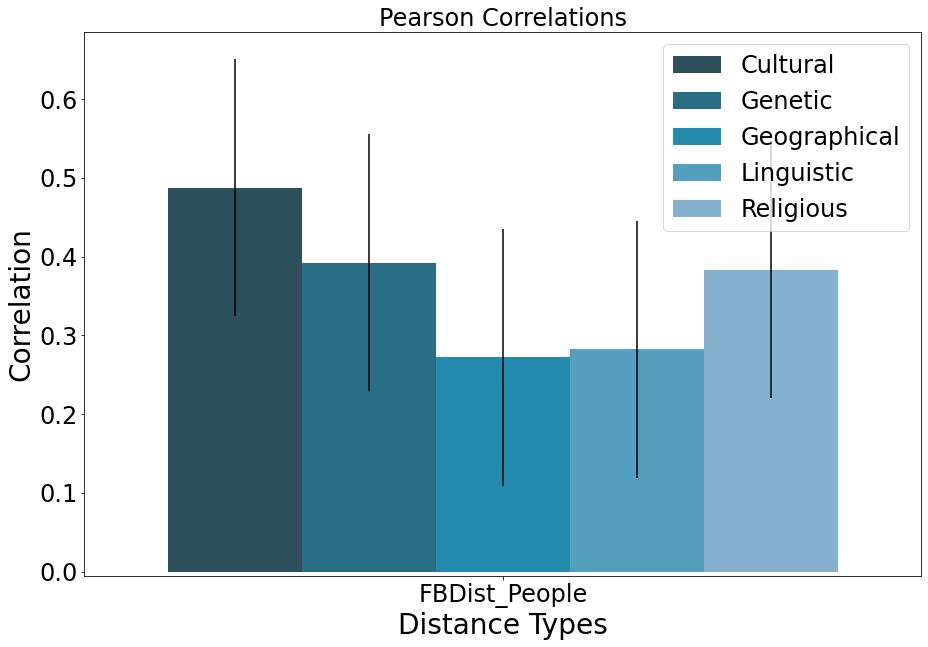

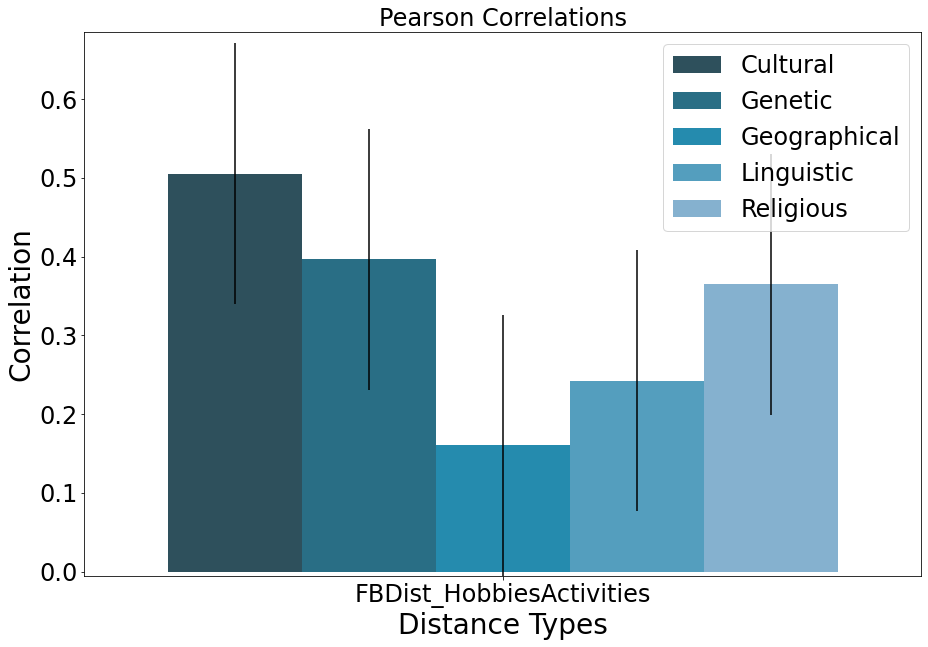

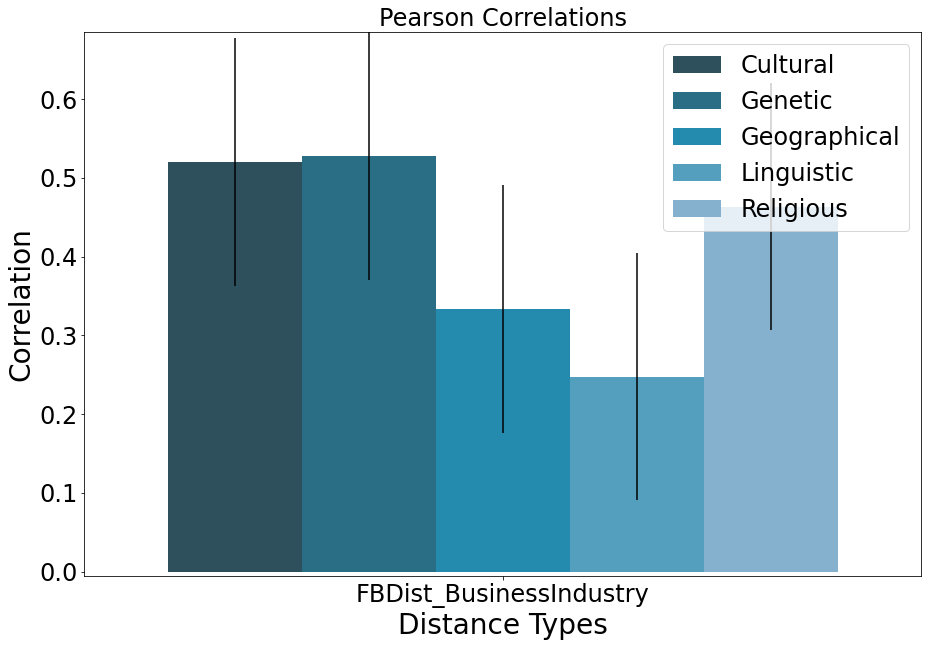

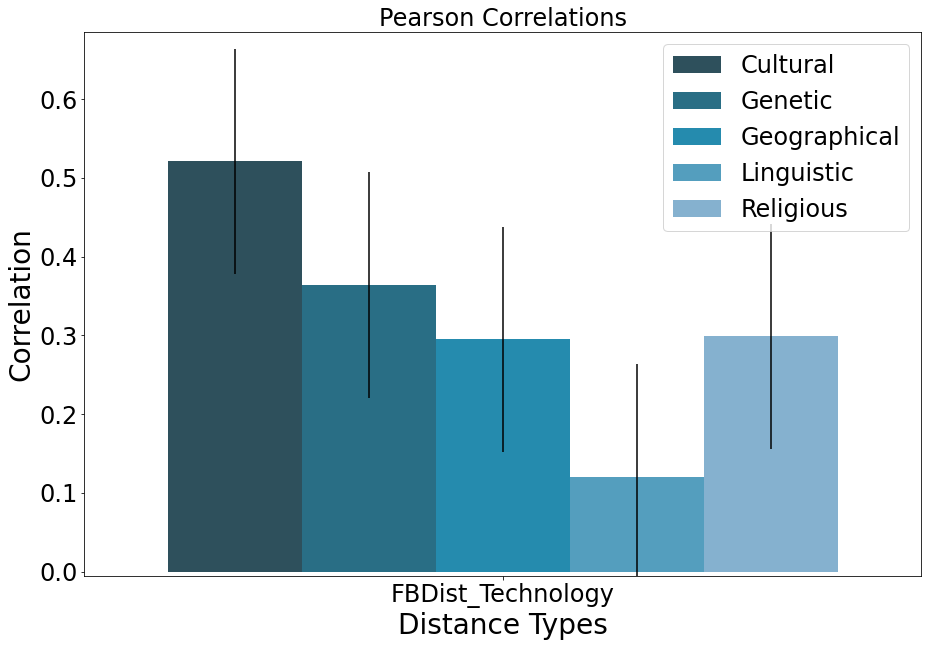

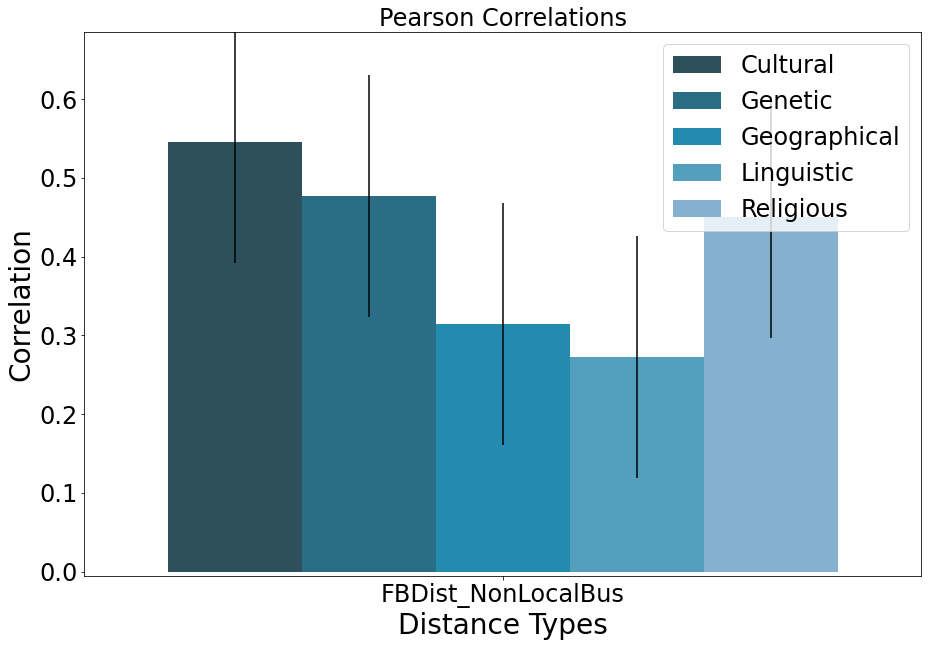

In [42]:
myfigs =[]
for f in corrs3m.Dist1.unique():
    lbound = corrs3m.mylci.min()
    ubound = corrs3m.mycci.max()
    fig, ax = plt.subplots(figsize=(15,10))
    sns.barplot(x="Dist1", y="mycorr", hue="DistType", data=corrs3m.loc[corrs3m.Dist1==f], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=corrs3m.loc[corrs3m.Dist1==f, 'myerr'].max())
    ax.set_ylim(bottom=lbound, top=ubound)
    ax.set_title('Pearson Correlations')
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Distance Types')
    ax.legend(loc='upper right')
    #plt.savefig(pathout+'CorrsFBCatsCom_' + f + '.pdf', dpi=300, bbox_inches='tight')
    myfigs.append(fig)
    plt.show()